In [1]:
import json
import numpy as np

def load_training_data(filename):
    """
    Reads TrainingInfo.json and structures all variables into e x n x m arrays.
    
    Args:
        filename (str): Path to the JSON file.
    
    Returns:
        data_dict (dict of lists of np.ndarray): Dictionary with keys:
            - "observations"
            - "actions"
            - "rewards"
            - "returns"
            - "advantages"
            - "baseline_loss"
            - "policy_loss"
        Each key contains a list where each element corresponds to an episode's data.
    """
    # Load JSON data
    with open(filename, "r") as f:
        data = json.load(f)

    # Initialize storage for all variables
    data_dict = {
        "observations": [],
        "actions": [],
        "rewards": [],
        "returns": [],
        "advantages": [],
        "baseline_loss": [],
        "policy_loss": []
    }

    # Process each episode
    for episode in data:
        data_dict["observations"].append(np.array(episode["observations"]))  # Shape: (n, m1)
        data_dict["actions"].append(np.array(episode["actions"]))  # Shape: (n, m2)
        data_dict["rewards"].append(np.array(episode["rewards"]))  # Shape: (n,)
        data_dict["returns"].append(np.array(episode["returns"]))  # Shape: (n,)
        data_dict["advantages"].append(np.array(episode["advantages"]))  # Shape: (n,)

        # Convert losses to NumPy arrays (ensuring correct shape)
        baseline_loss = episode["baseline_loss"]
        policy_loss = episode["policy_loss"]
        
        # Some losses might be scalars; ensure they are stored as NumPy arrays
        data_dict["baseline_loss"].append(np.array([baseline_loss]) if baseline_loss is not None else np.array([]))
        data_dict["policy_loss"].append(np.array([policy_loss]))

    return data_dict

In [2]:
data_dict = load_training_data("TrainingInfo.json")

In [24]:
print(data_dict["observations"][2].shape)
print(len(data_dict["actions"][0]))
print(len(data_dict["rewards"][0]))
print(len(data_dict["returns"][0]))
print(len(data_dict["advantages"][0]))
print(len(data_dict["baseline_loss"][0]))
print(len(data_dict["policy_loss"][0]))



(2016, 4)
2006
2006
2006
2006
1
1


In [17]:
import numpy as np
from ripser import ripser
from persim import wasserstein
import itertools

def compute_persistence_diagram(observations):
    """
    Computes the persistent homology of the observations.
    
    Args:
        observations (np.ndarray): The episode's observations (n x m).
    
    Returns:
        np.ndarray: The persistence diagram.
    """
    result = ripser(observations, maxdim=1)  # Compute up to 1D homology
    return result["dgms"]  # Returns a list [H0_diagram, H1_diagram]

def compute_wasserstein_distance(diag1, diag2):
    """
    Computes the Wasserstein distance between two persistence diagrams.
    
    Args:
        diag1 (list of np.ndarray): Persistence diagram from episode 1.
        diag2 (list of np.ndarray): Persistence diagram from episode 2.
    
    Returns:
        dict: Wasserstein distances for H0 and H1.
    """
    wasserstein_distances = {
        "H0": wasserstein(diag1[0], diag2[0]),  # Compare 0-dimensional features
        "H1": wasserstein(diag1[1], diag2[1])   # Compare 1-dimensional features
    }
    return wasserstein_distances

def compare_consecutive_episodes(data_dict):
    """
    Iterates over episodes in consecutive pairs and compares their
    persistent homology using the Wasserstein distance.
    
    Args:
        data_dict (dict): Dictionary containing structured training data.

    Returns:
        list: List of tuples with (episode_i, episode_j, wasserstein_distances).
    """
    wasserstein_results = []
    num_episodes = len(data_dict["observations"])
    
    # Compute persistence diagrams for all episodes
    persistence_diagrams = [
        compute_persistence_diagram(data_dict["observations"][e])
        for e in range(num_episodes)
    ]
    
    # Compare consecutive episode pairs only
    for i in range(num_episodes - 1):
        j = i + 1
        w_dist = compute_wasserstein_distance(persistence_diagrams[i],
                                              persistence_diagrams[j])
        wasserstein_results.append((i, j, w_dist))
        print(f"Wasserstein Distance between Episode {i} and {j}: "
              f"H0={w_dist['H0']}, H1={w_dist['H1']}")
    
    return wasserstein_results

Obs_was_dist = compare_consecutive_episodes(data_dict)

c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 0 and 1: H0=17.202388129569798, H1=3.3297221585830687


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 1 and 2: H0=7.240732350000975, H1=2.903884637814693


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 2 and 3: H0=4.997396455958151, H1=2.8115717944274023


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 3 and 4: H0=10.019881073435222, H1=3.5672586246672333


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 4 and 5: H0=5.680755977696284, H1=2.966650081084301


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 5 and 6: H0=4.93102906609308, H1=3.0916286405841498


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 6 and 7: H0=22.01490716866228, H1=6.291248472625355


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 7 and 8: H0=7.496534385019335, H1=4.38985098598865


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 8 and 9: H0=5.372942244145343, H1=4.276535563436595


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 9 and 10: H0=9.99330220805745, H1=4.176585398258475


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 10 and 11: H0=11.10142240756611, H1=5.4440909001576046


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 11 and 12: H0=11.683085212779783, H1=4.608835225941231


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 12 and 13: H0=3.7890637204361752, H1=4.339772041266359


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 13 and 14: H0=8.300758040523757, H1=3.4810841123390523


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 14 and 15: H0=17.515479654636692, H1=4.5060831767963165


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 15 and 16: H0=9.348472211668135, H1=3.2040614466506354


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 16 and 17: H0=10.78640307697862, H1=2.8192998952756514


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 17 and 18: H0=7.191646118328584, H1=2.7566846729956342


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 18 and 19: H0=7.527069946377926, H1=3.1549513940175724


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 19 and 20: H0=5.51407512160892, H1=3.2293142066489864


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 20 and 21: H0=7.255782019201657, H1=3.360567701900016


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 21 and 22: H0=10.146891574377763, H1=2.6206452763285797


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 22 and 23: H0=12.179435981973612, H1=2.9999627452133675


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 23 and 24: H0=7.441753519621475, H1=4.932977884053244


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 24 and 25: H0=6.5975344104451175, H1=4.575005803370663


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 25 and 26: H0=8.227588308733996, H1=2.99909933808768


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 26 and 27: H0=3.1450443633466674, H1=3.142089725445597


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 27 and 28: H0=5.619373428644319, H1=3.02336808872134


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 28 and 29: H0=9.756774276791583, H1=3.181141202838287


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 29 and 30: H0=7.823161020351269, H1=3.5433557046194575


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 30 and 31: H0=11.029966412242615, H1=3.0275449291112833


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 31 and 32: H0=2.2650271654015612, H1=2.320988513595239


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 32 and 33: H0=7.789515710631346, H1=2.505609282639441


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 33 and 34: H0=8.593641181651014, H1=2.79371868597119


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 34 and 35: H0=3.1041155452117515, H1=2.543802269774744


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 35 and 36: H0=13.801680139267226, H1=4.173202976995857


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 36 and 37: H0=15.897462563793145, H1=2.9718938730749533


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 37 and 38: H0=18.417566847075346, H1=2.6586521813394057


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 38 and 39: H0=4.316105460031914, H1=2.1392321422712843


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 39 and 40: H0=8.183787278270866, H1=2.301121643592159


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 40 and 41: H0=6.320754882389286, H1=1.8709010462862277


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 41 and 42: H0=12.684647825987572, H1=2.9558234841653475


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 42 and 43: H0=4.8646356392818, H1=1.742537800071021


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 43 and 44: H0=4.5729115805051315, H1=1.4347631205317828


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 44 and 45: H0=12.041626664932508, H1=2.0774123703771337


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 45 and 46: H0=10.111998947309587, H1=2.774805682238399


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 46 and 47: H0=7.254890703303729, H1=2.159183591652527


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 47 and 48: H0=5.704505049625625, H1=1.5126634460890476


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 48 and 49: H0=9.953240662401425, H1=1.7230541050939634


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 49 and 50: H0=4.49573190892376, H1=1.866568726797231


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 50 and 51: H0=4.444336823379945, H1=2.110328905448596


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 51 and 52: H0=10.469908448128693, H1=2.116761006074552


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 52 and 53: H0=6.021700029800069, H1=1.9737663738175542


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 53 and 54: H0=8.41162090836957, H1=2.5583364693675805


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 54 and 55: H0=3.2386095282035803, H1=2.1404589799937863


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 55 and 56: H0=5.035732193307674, H1=2.984844344037051


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 56 and 57: H0=8.631666786451358, H1=4.051292174992785


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 57 and 58: H0=16.16823627070676, H1=3.380342944890556


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 58 and 59: H0=4.961433900493973, H1=3.2634465385296347


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 59 and 60: H0=6.905805055622963, H1=3.0625348568071793


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 60 and 61: H0=13.180722987105984, H1=3.722516447566736


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 61 and 62: H0=8.811979040848938, H1=3.4409378316932755


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 62 and 63: H0=6.154091687609683, H1=3.6122657262452584


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 63 and 64: H0=4.690980511628643, H1=2.9559950804011295


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 64 and 65: H0=8.485897141297487, H1=3.077021397556856


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 65 and 66: H0=10.240312225650996, H1=4.000343522804929


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 66 and 67: H0=2.143965801689774, H1=3.7661751170100226


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 67 and 68: H0=7.890873053417809, H1=5.062364706375618


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 68 and 69: H0=4.209445309261839, H1=3.5884176636950786


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 69 and 70: H0=8.113062669652722, H1=2.7931953735125576


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 70 and 71: H0=4.815139306646834, H1=3.4044369476151837


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 71 and 72: H0=6.481255001332401, H1=3.1705143387047787


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 72 and 73: H0=13.543305444886602, H1=3.437875467457884


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 73 and 74: H0=9.281115711669809, H1=3.7811257236569107
Wasserstein Distance between Episode 74 and 75: H0=3.9213892161471278, H1=3.330070211195182


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 75 and 76: H0=9.946560807239488, H1=3.3212394843851065


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 76 and 77: H0=5.405756282334052, H1=2.570698826007762


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 77 and 78: H0=3.723886104468642, H1=3.0342314055671187


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 78 and 79: H0=5.110328534921364, H1=2.6336820919512953


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 79 and 80: H0=2.220461442592647, H1=2.373709711820658


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 80 and 81: H0=5.054018957500693, H1=3.086411820846952


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 81 and 82: H0=9.256005069809659, H1=5.348595803890447


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 82 and 83: H0=12.879388807668919, H1=4.410056138880204


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 83 and 84: H0=6.413168924839242, H1=3.467522426089864


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 84 and 85: H0=2.2432497748205718, H1=2.237448845339113


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 85 and 86: H0=11.645683408492594, H1=2.9024738046757883


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 86 and 87: H0=7.222725881378612, H1=2.457449365266056


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 87 and 88: H0=3.6625555050923198, H1=1.5973926980730613


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 88 and 89: H0=2.843673187721956, H1=2.1167695974217877


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 89 and 90: H0=5.822897204124042, H1=2.721249511216871


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 90 and 91: H0=10.299982330717377, H1=2.8851071552486696


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 91 and 92: H0=2.065621674082113, H1=2.891082430953184


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 92 and 93: H0=5.148557998863, H1=3.150358227708612


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 93 and 94: H0=6.556500582466144, H1=2.7896188561783686


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 94 and 95: H0=5.891701130488041, H1=2.3808340653706197


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 95 and 96: H0=4.103049803189134, H1=1.9478948505929519


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 96 and 97: H0=5.557750773022994, H1=2.341789426769647


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 97 and 98: H0=3.355893937330193, H1=2.39769574827843


c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\Bryan Lavender\.conda\envs\XAI_DT_WBox2d\lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Wasserstein Distance between Episode 98 and 99: H0=4.6799527246632, H1=2.91135154719157


In [18]:
Obs_was_dist

[(0, 1, {'H0': 17.202388129569798, 'H1': 3.3297221585830687}),
 (1, 2, {'H0': 7.240732350000975, 'H1': 2.903884637814693}),
 (2, 3, {'H0': 4.997396455958151, 'H1': 2.8115717944274023}),
 (3, 4, {'H0': 10.019881073435222, 'H1': 3.5672586246672333}),
 (4, 5, {'H0': 5.680755977696284, 'H1': 2.966650081084301}),
 (5, 6, {'H0': 4.93102906609308, 'H1': 3.0916286405841498}),
 (6, 7, {'H0': 22.01490716866228, 'H1': 6.291248472625355}),
 (7, 8, {'H0': 7.496534385019335, 'H1': 4.38985098598865}),
 (8, 9, {'H0': 5.372942244145343, 'H1': 4.276535563436595}),
 (9, 10, {'H0': 9.99330220805745, 'H1': 4.176585398258475}),
 (10, 11, {'H0': 11.10142240756611, 'H1': 5.4440909001576046}),
 (11, 12, {'H0': 11.683085212779783, 'H1': 4.608835225941231}),
 (12, 13, {'H0': 3.7890637204361752, 'H1': 4.339772041266359}),
 (13, 14, {'H0': 8.300758040523757, 'H1': 3.4810841123390523}),
 (14, 15, {'H0': 17.515479654636692, 'H1': 4.5060831767963165}),
 (15, 16, {'H0': 9.348472211668135, 'H1': 3.2040614466506354}),
 

In [19]:
with open("ObsWassDist.json", "w") as f:
    json.dump(Obs_was_dist, f, indent=4)
    

In [27]:
import matplotlib.pyplot as plt
def plot_summed_metrics_and_wasserstein(data_dict, wasserstein_results):
    """
    1. Sums rewards, returns, advantages per episode (assuming each is per-step).
    2. Plots H0, H1 (from Wasserstein distances of consecutive episodes) 
       alongside these summed metrics in subplots.
    
    Args:
        data_dict (dict): Dictionary containing structured training data with keys:
                          ["observations", "rewards", "returns", "advantages", ...]
                          where each is a list of lists, 
                          e.g. data_dict["rewards"][ep] -> reward at each step of ep.
        wasserstein_results (list): Output of compare_consecutive_episodes, i.e.
                                    a list of tuples (i, j, w_dist).
    """
    
    # -- 1. Extract H0 and H1 from consecutive Wasserstein results --
    h0_list = []
    h1_list = []
    for (i, j, w_dist) in wasserstein_results:
        h0_list.append(w_dist["H0"])
        h1_list.append(w_dist["H1"])
    
    # Indices for episodes and consecutive pairs
    num_episodes = len(data_dict["observations"])
    x_wdist     = range(num_episodes - 1)  # for consecutive pairs
    x_episodes  = range(num_episodes)      # for per-episode metrics
    
    # -- 2. Prepare or sum up the metrics per episode --
    # Check if certain keys exist and sum them if they do.
    # For example, data_dict["rewards"][ep] might be a list of reward values for each step in episode ep.
    summed_rewards     = [sum(ep_rewards) for ep_rewards     in data_dict["rewards"]]     if "rewards"     in data_dict else None
    summed_returns     = [sum(ep_returns) for ep_returns     in data_dict["returns"]]     if "returns"     in data_dict else None
    summed_advantages  = [sum(ep_advs)    for ep_advs        in data_dict["advantages"]]  if "advantages"  in data_dict else None
    # If "losses" is already per-episode, you can use it directly.
    # If it's also per-step, you'd do the same summation approach:
    summed_losses      = [sum(ep_losses)  for ep_losses      in data_dict["losses"]]      if "losses"      in data_dict else None
    
    # -- 3. Create subplots --
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    axes = axes.flatten()  # flatten to a 1D list of axes for easier indexing
    
    # Subplot 0: Plot H0/H1 from Wasserstein distances
    axes[0].plot(x_wdist, h0_list, marker='o', label='H0')
    axes[0].plot(x_wdist, h1_list, marker='s', label='H1')
    axes[0].set_title('Wasserstein Distances (Consecutive Episodes)')
    axes[0].set_xlabel('Consecutive Pair Index')
    axes[0].set_ylabel('Distance')
    axes[0].legend()
    
    # Subplot 1: Sum of Rewards
    if summed_rewards is not None:
        axes[1].plot(x_episodes, summed_rewards, marker='o', color='green', label='Sum of Rewards')
        axes[1].set_title('Summed Rewards')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Reward Sum')
    
    # Subplot 2: Sum of Returns
    if summed_returns is not None:
        axes[2].plot(x_episodes, summed_returns, marker='o', color='blue', label='Sum of Returns')
        axes[2].set_title('Summed Returns')
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Return Sum')
    
    # Subplot 3: Sum of Advantages
    if summed_advantages is not None:
        axes[3].plot(x_episodes, summed_advantages, marker='o', color='purple', label='Sum of Advantages')
        axes[3].set_title('Summed Advantages')
        axes[3].set_xlabel('Episode')
        axes[3].set_ylabel('Advantage Sum')
    
    # Subplot 4: Sum of Losses (if available)
    if summed_losses is not None:
        axes[4].plot(x_episodes, summed_losses, marker='o', color='red', label='Sum of Losses')
        axes[4].set_title('Summed Losses')
        axes[4].set_xlabel('Episode')
        axes[4].set_ylabel('Loss Sum')
    
    # Subplot 5: Either leave empty or add a custom plot
    axes[5].set_visible(False)
    
    plt.tight_layout()
    plt.show()

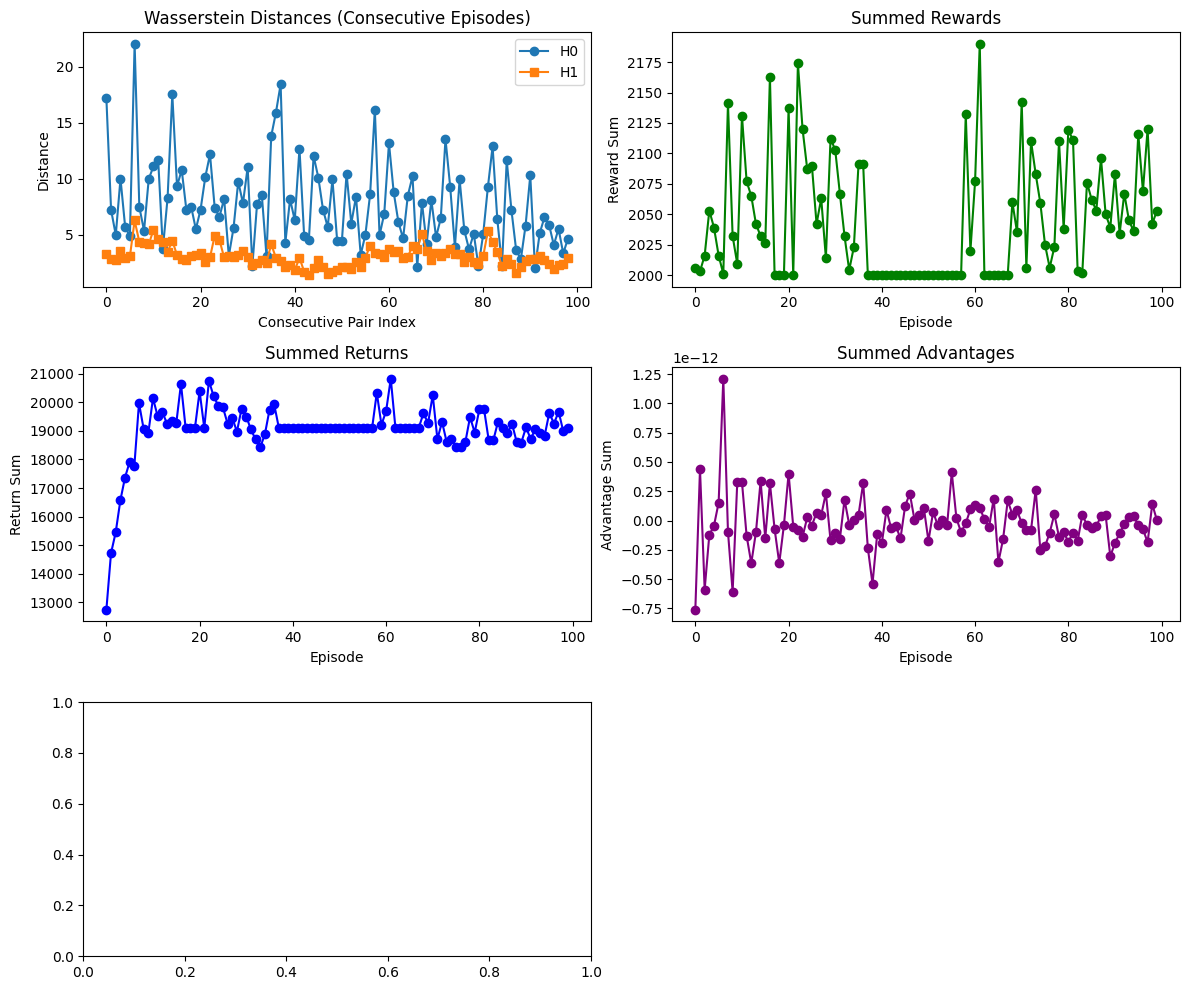

In [28]:
plot_summed_metrics_and_wasserstein(data_dict, Obs_was_dist)

In [29]:
import matplotlib.pyplot as plt

def plot_all_on_single_graph_no_sum_losses(data_dict, wasserstein_results):
    """
    Plots summed rewards, returns, advantages, and NON-summed losses on one axis,
    while plotting the Wasserstein distances (H0, H1) on a second y-axis.
    
    Args:
        data_dict (dict): Structured training data with keys (for example):
                          - "rewards": list of lists of rewards per episode
                          - "returns": list of lists of returns per episode
                          - "advantages": list of lists of advantages per episode
                          - "losses": list of per-episode loss values (or list of lists 
                                      if you truly need to keep them as-is)
                          - "observations": list of lists (one list of observations per episode)
                          
        wasserstein_results (list): A list of tuples (i, j, w_dist) from
                                    compare_consecutive_episodes(), where:
                                       i: episode index
                                       j: episode index (i+1)
                                       w_dist: dict like {"H0": val, "H1": val}.
    """
    num_episodes = len(data_dict["observations"])
    
    # ---- 1. Summation of per-step metrics (except losses) ----
    sum_rewards = (
        [sum(ep_rewards) for ep_rewards in data_dict["rewards"]]
        if "rewards" in data_dict else None
    )
    sum_returns = (
        [sum(ep_returns) for ep_returns in data_dict["returns"]]
        if "returns" in data_dict else None
    )
    sum_advantages = (
        [sum(ep_advs) for ep_advs in data_dict["advantages"]]
        if "advantages" in data_dict else None
    )
    
    # ---- 2. Keep losses as-is (no summation) ----
    #    This code expects one loss value per episode. If you have multiple steps per episode,
    #    and you'd prefer to plot them "as is" (e.g., a mean or final step), be sure that
    #    data_dict["losses"] is already the right shape: one value per episode.
    if "losses" in data_dict:
        # If it's already a list of single values per episode:
        losses = data_dict["losses"]
    else:
        losses = None
    
    # ---- 3. Extract Wasserstein distances (H0, H1) for consecutive episodes ----
    h0_list = []
    h1_list = []
    x_wdist = []
    
    for (i, j, w_dist) in wasserstein_results:
        # Typically j = i+1, so let's use "j" for the x-axis location.
        x_wdist.append(j)
        h0_list.append(w_dist["H0"])
        h1_list.append(w_dist["H1"])
    
    # ---- 4. Set up a single figure with a primary axis (ax1) and a twin axis (ax2) ----
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # The x-values for the per-episode metrics are simply range(num_episodes).
    x_episodes = range(num_episodes)
    
    # Plot each metric on ax1 if it exists:
    if sum_rewards is not None:
        ax1.plot(x_episodes, sum_rewards, marker='o', label='Sum of Rewards')
    if sum_returns is not None:
        ax1.plot(x_episodes, sum_returns, marker='s', label='Sum of Returns')
    if sum_advantages is not None:
        ax1.plot(x_episodes, sum_advantages, marker='^', label='Sum of Advantages')
    if losses is not None:
        ax1.plot(x_episodes, losses, marker='x', label='Losses', color='red')
    
    # Configure ax1
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Summed RL Metrics (and non-summed Losses)')
    ax1.set_title('RL Metrics and Wasserstein Distances (H0, H1) on One Graph')
    
    # ---- 5. Create the twin axis (ax2) for H0/H1 ----
    ax2 = ax1.twinx()
    
    ax2.plot(x_wdist, h0_list, color='tab:red', marker='o', linestyle='--', label='H0')
    ax2.plot(x_wdist, h1_list, color='tab:orange', marker='s', linestyle='--', label='H1')
    ax2.set_ylabel('Wasserstein Distances')
    
    # ---- 6. Combine legends from both axes ----
    lines_ax1, labels_ax1 = ax1.get_legend_handles_labels()
    lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_ax1 + lines_ax2, labels_ax1 + labels_ax2, loc='best')
    
    # ---- 7. Show the plot ----
    plt.tight_layout()
    plt.show()


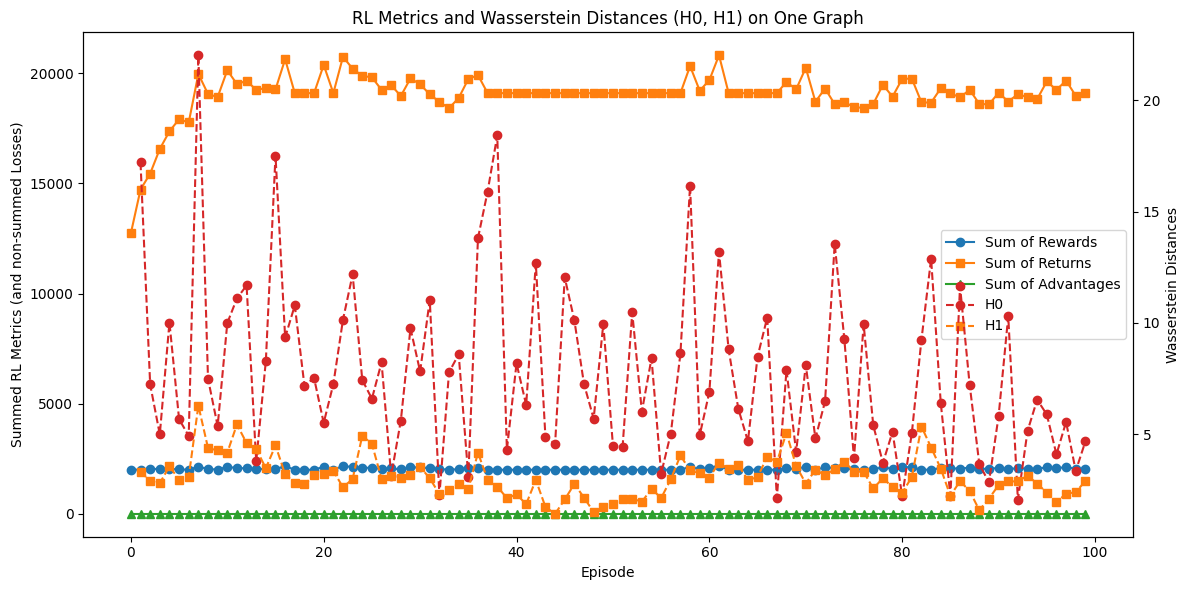

In [31]:
plot_all_on_single_graph_no_sum_losses(data_dict, Obs_was_dist)

In [3]:
import numpy as np
import kmapper as km
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# 1. Generate some sample data (e.g., Swiss roll)
data, color = datasets.make_swiss_roll(n_samples=1000, noise=0.05)

# 2. Normalize / scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 3. Initialize the KeplerMapper object
mapper = km.KeplerMapper(verbose=1)

# 4. Define a lens (filter function)
#    Here we use the default projection = 'sum' as a simple example.
#    You could also use PCA, distance functions, or your own custom function.
lens = mapper.fit_transform(data_scaled, projection="sum")

# 5. Create the topological network (graph)
#    - cover: how we cover the lens values (n_cubes=10 means 10 overlapping bins)
#    - overlap: fraction of overlap between bins
#    - clusterer: the clustering algorithm used in each bin (DBSCAN here)
graph = mapper.map(
    lens,
    data_scaled,
    cover=km.Cover(n_cubes=10, perc_overlap=0.2),
    clusterer=DBSCAN(eps=0.5, min_samples=5)
)

# 6. Visualize and save to an interactive HTML file
mapper.visualize(graph,
                 path_html="mapper_swiss_roll.html",
                 title="Mapper on Swiss Roll")

print("Mapper graph constructed and HTML visualization saved.")

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1000, 3)

..Projecting data using: sum

..Scaling with: MinMaxScaler()

Mapping on data shaped (1000, 3) using lens shaped (1000, 1)

Creating 10 hypercubes.

Created 22 edges and 21 nodes in 0:00:00.016004.
Wrote visualization to: mapper_swiss_roll.html
Mapper graph constructed and HTML visualization saved.
